In [76]:
import pandas as pd


housing = pd.read_csv("datasets/housing/housing.csv")

In [77]:
# create a test set
import numpy as np
np.random.seed(42)

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)

In [78]:
# split housing into income categories and stratify based on median income
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])


from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [79]:
# prepare for machine learning
housing = strat_train_set.drop("median_house_value", axis=1) 
housing_labels = strat_train_set["median_house_value"].copy()

# data cleaning
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

housing_num = housing.drop("ocean_proximity", axis=1)

imputer.fit(housing_num)
X = imputer.transform(housing_num)

housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [80]:
# handling categorical attribute ocean_proximity

housing_cat = housing[["ocean_proximity"]]

from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [83]:
# creating a custom transformer to add additional attributes

from sklearn.base import BaseEstimator, TransformerMixin

# get the right column indices: safer than hard-coding indices
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    # initialize and take in extra hyperparameter to decide whether to add bedrooms_per_room
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    # we need a fit method to satisfy the TransformerMixin, but it doesn't do anything in this case
    # just reurns the transformer instance (self)
    def fit(self, X, y=None):
        return self
    # now we implement the transform method itself in order to add the new attributes
    # X is the dataset to be transformed
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns) + ["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,income_cat,rooms_per_household,population_per_household
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND,2,5.485836,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN,5,6.927083,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.875,INLAND,2,5.393333,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN,2,3.886128,1.859213
20496,-118.7,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN,3,6.096552,3.167241


In [85]:
# now we can define a transformation pipeline to handle all the transformations in the right order

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [86]:
# we can use the ColumnTransformer to apply the transformations to the numerical and categorical columns
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

In [109]:
# we will now fine-tune these four algorithms using Random Search and Grid Search with 5-fold cross-validation (CV)

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

# we will start with linear regression

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

# show rmse
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)

lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68380.70036286271

In [125]:
# lets see what the result is using CV

from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=5)
lin_rmse_scores = np.sqrt(-lin_scores)

lin_rmse = lin_rmse_scores.mean()
lin_rmse

599923795641672.9

In [127]:
# lets see if fit_intercept=false gives a better result

lin_reg_intercept = LinearRegression(fit_intercept=False)
lin_reg_intercept.fit(housing_prepared, housing_labels)

housing_predictions = lin_reg_intercept.predict(housing_prepared)

lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68376.51254853733

In [128]:
# lets see if we can get a better result using Cross Validation

from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(lin_reg_intercept, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=5)
lin_rmse_scores = np.sqrt(-lin_scores)

lin_rmse = lin_rmse_scores.mean()
lin_rmse

68942.93849040948

In [90]:
# doesnt seem like it, lets try decision tree

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()

tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)

tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [99]:
# okay now we will try cross validation for decision tree using 5-fold CV

from sklearn.model_selection import cross_val_score

tree_scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=5)
tree_rmse_scores = np.sqrt(-tree_scores)

tree_rmse_cv = tree_rmse_scores.mean()
tree_rmse_cv


70716.65872621792

In [52]:

# now use grid search to fine-tune the hyperparameters

from sklearn.model_selection import GridSearchCV

param_grid = {
    'splitter': ['best', 'random'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 20, 30, 40],
}

grid_search = GridSearchCV(tree_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

grid_search.best_params_

{'max_features': None,
 'max_leaf_nodes': None,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'splitter': 'best'}

In [49]:
# lets look at the rmse of the best set of hyperparameters by getting the best score and rmse

grid_search.best_estimator_.score(housing_prepared, housing_labels)

np.sqrt(-grid_search.best_score_)



63136.66751474407

In [56]:
# now lets see if we can get a better result using Random Search

from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    'splitter': ['best', 'random'],
    'min_samples_split': randint(low=2, high=10),
    'min_samples_leaf': randint(low=1, high=5),
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 20, 30, 40],
}

rnd_search = RandomizedSearchCV(tree_reg, param_distribs, n_iter=100, cv=5, scoring='neg_mean_squared_error', random_state=42)

rnd_search.fit(housing_prepared, housing_labels)

rnd_search.best_params_

{'max_features': None,
 'max_leaf_nodes': 40,
 'min_samples_leaf': 3,
 'min_samples_split': 3,
 'splitter': 'best'}

In [57]:
# lets see what the rmse is for those hyperparameters


rnd_search.best_estimator_.score(housing_prepared, housing_labels)

np.sqrt(-rnd_search.best_score_)


63604.46651955434

In [140]:
# next we will try a random forest regressor on default hyperparameters first abd then try to fine-tune it


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

forest_reg = RandomForestRegressor()

# cv on default hyperparameters

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=5)
forest_rmse_scores = np.sqrt(-forest_scores)

print(forest_rmse_scores)
print(forest_rmse_scores.mean())
print(forest_rmse_scores.std())

[50336.3192997  50017.32713971 49877.19907889 51889.04953032
 51371.20208998]
50698.21942771913
792.419386524501


In [ ]:
# grid search
param_grid = {
    'n_estimators': [3, 10, 30],
    'max_features': [2, 4, 6, 8],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

forest_grid_rmse = np.sqrt(-grid_search.best_score_)
forest_grid_rmse

In [ ]:
# random search

param_distribs = {
    'n_estimators': randint(low=1, high=200),
    'max_features': randint(low=1, high=8),
    'max_depth': [None, 5, 10],
    'min_samples_split': randint(low=2, high=10),
    'min_samples_leaf': randint(low=1, high=5),
    'bootstrap': [True, False]
}

rnd_search = RandomizedSearchCV(forest_reg, param_distribs, n_iter=100, cv=5, scoring='neg_mean_squared_error', random_state=42)

rnd_search.fit(housing_prepared, housing_labels)

forest_rnd_rmse = np.sqrt(-rnd_search.best_score_)

forest_rnd_rmse

In [63]:
# show the best hyperparameters for grid search and random search

print(grid_search.best_params_)
print(rnd_search.best_params_)


{'bootstrap': False, 'max_depth': None, 'max_features': 8, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 30}
{'bootstrap': False, 'max_depth': None, 'max_features': 7, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 154}


In [141]:
# lets retry grid search with the learnings from the previous steps

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': [6, 8, 10],
    'min_samples_split': [5],
    'min_samples_leaf': [2, 3],
    'max_features': [8, 10]
}
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)


grid_search.fit(housing_prepared, housing_labels)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': [8, 10], 'min_samples_leaf': [2, 3],
                         'min_samples_split': [5],
                         'n_estimators': [100, 200, 300]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [143]:
# lets see what the rmse is for those hyperparameters

grid_search.best_estimator_.score(housing_prepared, housing_labels)

forest_grid_rmse_2 = np.sqrt(-grid_search.best_score_)
forest_grid_params_2 = grid_search.best_params_

print(forest_grid_rmse_2)
print(forest_grid_params_2)

49973.99585437365
{'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}


In [137]:
# lastly we will try to get the best result for SVR

# first we run it on default hyperparameters

from sklearn.svm import SVR

svm_reg = SVR()

svm_reg.fit(housing_prepared, housing_labels)

housing_predictions = svm_reg.predict(housing_prepared)

svm_mse = mean_squared_error(housing_labels, housing_predictions)

svm_rmse = np.sqrt(svm_mse)

svm_rmse

118451.153930123

In [138]:
# lets see if we can get a better result using Cross Validation

from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=5)
svm_rmse_scores = np.sqrt(-svm_scores)

svm_rmse = svm_rmse_scores.mean()
svm_rmse

118540.23860268938

In [70]:
# show parameters

svm_reg.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [66]:
# now use grid search to fine-tune the hyperparameters

from sklearn.model_selection import GridSearchCV

param_grid = [
    {'kernel': ['linear'], 'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0, 10000.0, 30000.0]},
    {'kernel': ['rbf'], 'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0], 'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
]

svm_reg = SVR()

grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

grid_search.best_params_

{'C': 1000.0, 'kernel': 'linear'}

In [68]:
svm_grid_rmse = np.sqrt(-grid_search.best_score_)
svm_grid_rmse

70279.3095484106

In [69]:
# now lets try random search

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

param_distribs = {
    'kernel': ['linear', 'rbf'],
    'C': reciprocal(20, 200000),
    'gamma': expon(scale=1.0),
}

rnd_search = RandomizedSearchCV(svm_reg, param_distribs, n_iter=100, cv=5, scoring='neg_mean_squared_error', random_state=42)

rnd_search.fit(housing_prepared, housing_labels)

svm_rnd_rmse = np.sqrt(-rnd_search.best_score_)
svm_rnd_rmse

55089.780936766634

In [139]:
# show parameters

rnd_search.best_params_

{'C': 190046.48700269678, 'gamma': 0.19349404041660798, 'kernel': 'rbf'}

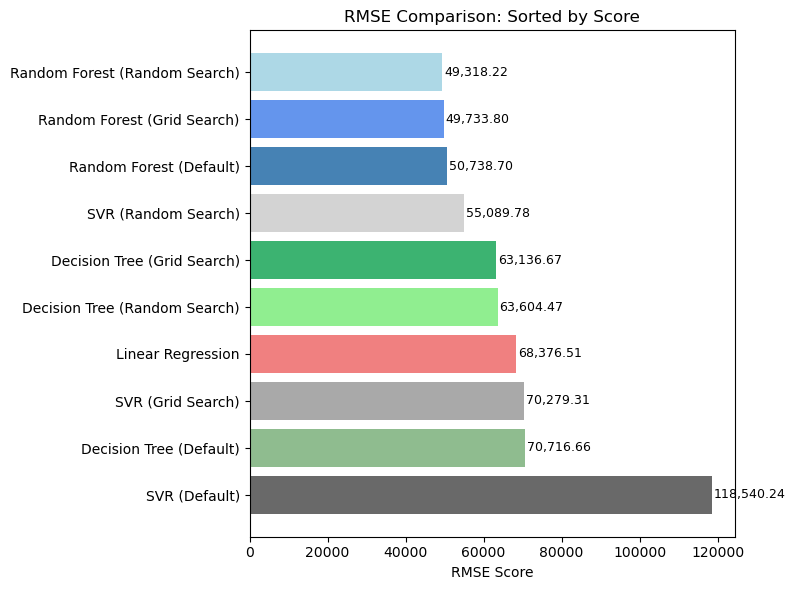

In [156]:
# visualize the results with learning curves

import matplotlib.pyplot as plt

import numpy as np

# RMSE scores for different models (including default, grid search, and random search results)
models = [
    'Linear Regression', 
    'Decision Tree (Default)', 'Decision Tree (Grid Search)', 'Decision Tree (Random Search)', 
    'Random Forest (Default)', 'Random Forest (Grid Search)', 'Random Forest (Random Search)',
    'SVR (Default)', 'SVR (Grid Search)', 'SVR (Random Search)'
]

rmse_scores = [
    68376.51,  # Linear Regression
    70716.66,  # Decision Tree Default
    63136.67,  # Decision Tree Grid Search
    63604.47,  # Decision Tree Random Search
    50738.70,  # Random Forest Default
    49733.80,  # Random Forest Grid Search
    49318.22,  # Random Forest Random Search
    118540.24, # SVR Default
    70279.31,  # SVR Grid Search
    55089.78   # SVR Random Search
]

# Colors for the models, with main color and two shades for each approach
colors = [
    'lightcoral',  # Linear Regression
    'darkseagreen', 'mediumseagreen', 'lightgreen',  # Decision Tree
    'steelblue', 'cornflowerblue', 'lightblue',  # Random Forest
    'dimgray', 'darkgray', 'lightgray'  # SVR
]

# Sort by RMSE values (ascending order)
sorted_indices = np.argsort(rmse_scores)[::-1]  
models_sorted = [models[i] for i in sorted_indices]
rmse_scores_sorted = [rmse_scores[i] for i in sorted_indices]
colors_sorted = [colors[i] for i in sorted_indices]

# Create the bar chart with the sorted values
plt.figure(figsize=(8, 6))
bars = plt.barh(models_sorted, rmse_scores_sorted, color=colors_sorted)
plt.xlabel('RMSE Score')
plt.title('RMSE Comparison: Sorted by Score')

# Adding RMSE values as labels next to the bars
for bar in bars:
    plt.text(
        bar.get_width() + 500,  # Offset slightly to the right of the bar
        bar.get_y() + bar.get_height() / 2,
        f'{bar.get_width():,.2f}',  # Display value with comma for thousands separator and two decimal places
        va='center',  # Vertically align center
        fontsize=9
    )

plt.tight_layout()

# Save and show the plot
plt.show()

